In [1]:
from data import Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
phq9 = Data('phq9', is_remove_outlier=True)
gad7 = Data('gad7', is_remove_outlier=True)
pss = Data('pss', is_remove_outlier=True)
isi = Data('isi', is_remove_outlier=True)


In [3]:
# plot time
def get_melt_df(scale):
    df = scale.df
    time_cols = [col for col in df.columns if col.startswith('time')]
    df_time = df[time_cols + ['export_id']]
    df_time = df_time.melt(var_name='Question', value_name='Response Time (s)', id_vars='export_id')
    df_time['Question'] = df_time['Question'].str.replace('time', 'Q')
    return df_time

get_melt_df(phq9)

,export_id,Question,Response Time (s)
0,61793,Q1,2.47
1,61809,Q1,8.22
2,61737,Q1,1.88
3,61738,Q1,1.74
4,61739,Q1,5.54
...,...,...,...
210028,86063,Q9,4.50
210029,86064,Q9,4.77
210030,86065,Q9,3.76
210031,101218,Q9,4.70


In [4]:
get_melt_df(phq9)['export_id'].nunique()

23337

Plot

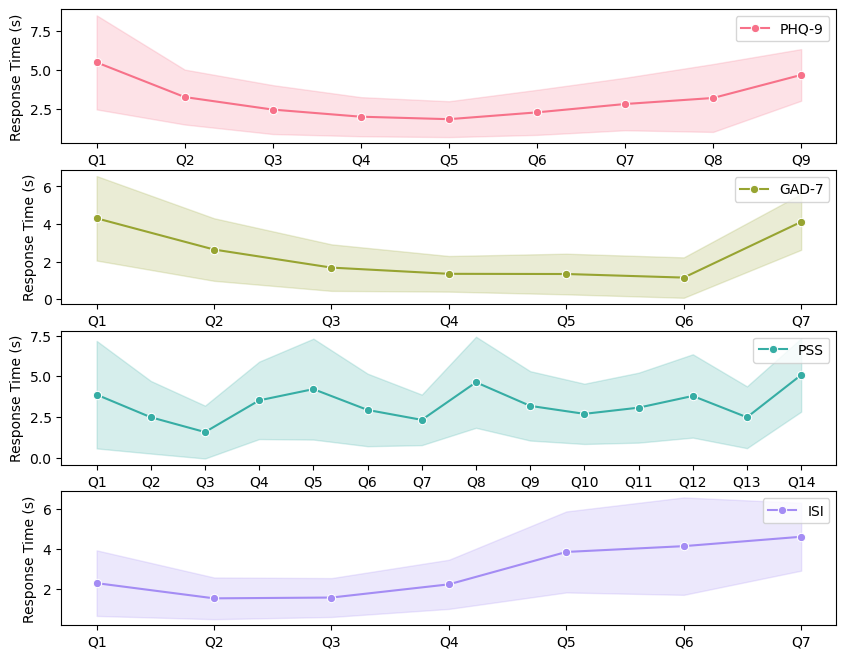

In [5]:
fig, ax = plt.subplots(4, 1,figsize=(10, 8))
ax = ax.flatten()

palette = sns.color_palette("husl", 4)
labels = ['PHQ-9', 'GAD-7', 'PSS', 'ISI']

for i, scale in enumerate([phq9, gad7, pss, isi]):
    sns.lineplot(
        data=get_melt_df(scale), 
        x='Question', y='Response Time (s)',
        err_style="band", errorbar=("sd", 0.5),
        estimator='median',
        marker='o',
        color=palette[i],
        label=labels[i],
        ax=ax[i]
    )
    ax[i].set_xlabel('')

# handles, labels = ax[-1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right')

To address the issue of non-negative and right-skewed distribution of reaction latencies, we performed generalized linear mixed model (GLMM) analyses with word counts as an independent continuous variable, and response time as the dependent variable.

In [6]:
def prepare(scale, name):  
    df = get_melt_df(scale)
    df_wc = pd.read_excel('data/Psychological_Assessment_Scales_Content.xlsx', sheet_name=name)
    df['Index'] = df['Question'].str.replace('Q', '')
    df['Index'] = df['Index'].astype(int)
    df = pd.merge(df, df_wc, how='left', on='Index')
    df = df.rename(columns={
        'Response Time (s)': 'Response_Time'
    })
    df['Scale_Name'] = name
    return df
df = pd.concat([prepare(phq9, 'PHQ-9'), prepare(gad7, 'PHQ-9'), prepare(isi, 'ISI'), prepare(pss, 'PSS')])
df

,export_id,Question,Response_Time,Index,Question_Context,Word_Count,Scale_Name
0,61793,Q1,2.47,1,做事时提不起劲或没有兴趣,12,PHQ-9
1,61809,Q1,8.22,1,做事时提不起劲或没有兴趣,12,PHQ-9
2,61737,Q1,1.88,1,做事时提不起劲或没有兴趣,12,PHQ-9
3,61738,Q1,1.74,1,做事时提不起劲或没有兴趣,12,PHQ-9
4,61739,Q1,5.54,1,做事时提不起劲或没有兴趣,12,PHQ-9
...,...,...,...,...,...,...,...
328113,86063,Q14,4.23,14,常感到困难的事情堆积如山，而自己无法克服它们,22,PSS
328114,86064,Q14,4.33,14,常感到困难的事情堆积如山，而自己无法克服它们,22,PSS
328115,86065,Q14,6.70,14,常感到困难的事情堆积如山，而自己无法克服它们,22,PSS
328116,101218,Q14,1.56,14,常感到困难的事情堆积如山，而自己无法克服它们,22,PSS


In [7]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the model formula
formula = 'Response_Time ~ Word_Count'

# Fit the GLMM with 'export_id' as a random effect
model = smf.mixedlm(formula, df, groups=df['export_id'], re_formula='~Word_Count').fit()
print(model.summary())


/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   Response_Time
No. Observations:   864442    Method:               REML         
No. Groups:         24249     Scale:                14.2413      
Min. group size:    7         Log-Likelihood:       -2399099.3215
Max. group size:    37        Converged:            Yes          
Mean group size:    35.6                                         
-----------------------------------------------------------------
                       Coef. Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              2.662    0.011 233.506 0.000  2.640  2.684
Word_Count             0.075    0.001 117.010 0.000  0.074  0.076
Group Var              0.849    0.009                            
Group x Word_Count Cov 0.040    0.000                            
Word_Count Var         0.002    0.000                            



/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/iolib/summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
